In [1]:
# !pip install investpy prettytable

In [2]:
import investpy
import pandas as pd
from scipy.stats import norm, mstats
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 7)

# Value-at-Risk Estimation and Backtesting

This example shows how to estimate the value-at-risk (VaR) using three methods and perform a VaR backtesting analysis. The three methods are:

- Normal distribution

- Historical simulation

- Exponential weighted moving average (EWMA)

Value-at-risk is a statistical method that quantifies the risk level associated with a portfolio. The VaR measures the maximum amount of loss over a specified time horizon and at a given confidence level.

Backtesting measures the accuracy of the VaR calculations. Using VaR methods, the loss forecast is calculated and then compared to the actual losses at the end of the next day. The degree of difference between the predicted and actual losses indicates whether the VaR model is underestimating or overestimating the risk. As such, backtesting looks retrospectively at data and helps to assess the VaR model.

The three estimation methods used in this example estimate the VaR at 95% and 99% confidence levels.

## Load the Data and Define the Test Window


Load the data. The data used in this example is from a time series of returns on the S&P index from 1993 through 2003.

In [4]:
sp_index = investpy.get_index_historical_data(
    index="S&P 500", country="United States", from_date="01/01/2011", to_date="1/1/2022"
)

In [5]:
sp_index

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2011-01-03,1257.62,1276.17,1257.62,1271.87,0,USD
2011-01-04,1272.95,1274.12,1262.66,1270.20,0,USD
2011-01-05,1268.78,1277.63,1265.36,1276.56,0,USD
2011-01-06,1276.29,1278.17,1270.43,1273.85,0,USD
2011-01-07,1274.41,1276.83,1261.70,1271.50,0,USD
...,...,...,...,...,...,...
2021-12-27,4733.99,4791.49,4733.99,4791.19,0,USD
2021-12-28,4795.49,4807.02,4780.04,4786.36,0,USD
2021-12-29,4788.64,4804.06,4778.08,4793.06,0,USD


In [6]:
VaRExample = sp_index[["Close"]]
VaRExample.index = pd.to_datetime(VaRExample.index)

In [7]:
def tick2ret(data):
    return data.pct_change(1)

In [8]:
Returns = tick2ret(VaRExample)
# Returns = Returns['Close'].to_list()
DateReturns = Returns.index
SampleSize = len(Returns)

Define the estimation window as 250 trading days. The test window starts on the first day in 1996 and runs through the end of the sample.

In [9]:
TestWindowStart = DateReturns.get_loc("2012").start
TestWindow = list(range(TestWindowStart, SampleSize + 1))
EstimationWindowSize = 250

These values mean that there is at most a 5% and 1% probability, respectively, that the loss incurred will be greater than the maximum threshold (that is, greater than the VaR).

In [10]:
pVaR = [0.05, 0.01]

## Compute the VaR Using the Normal Distribution Method

For the normal distribution method, assume that the profit and loss of the portfolio is normally distributed. Using this assumption, compute the VaR by multiplying the z-score, at each confidence level by the standard deviation of the returns. Because VaR backtesting looks retrospectively at data, the VaR "today" is computed based on values of the returns in the last N = 250 days leading to, but not including, "today."



In [11]:
Zscore = norm.ppf(pVaR)
Normal95 = np.zeros(len(TestWindow) + 1).reshape(-1, 1)
Normal99 = np.zeros(len(TestWindow) + 1).reshape(-1, 1)


for t in TestWindow:
    i = t - TestWindowStart + 1
    EstimationWindow = list(range(t - EstimationWindowSize, t - 1))

    Sigma = np.std(Returns[EstimationWindow[0] : EstimationWindow[-1] + 1])
    Normal95[i] = -Zscore[0] * Sigma
    Normal99[i] = -Zscore[1] * Sigma;

Text(0.5, 1.0, 'VaR Estimation Using the Normal Distribution Method')

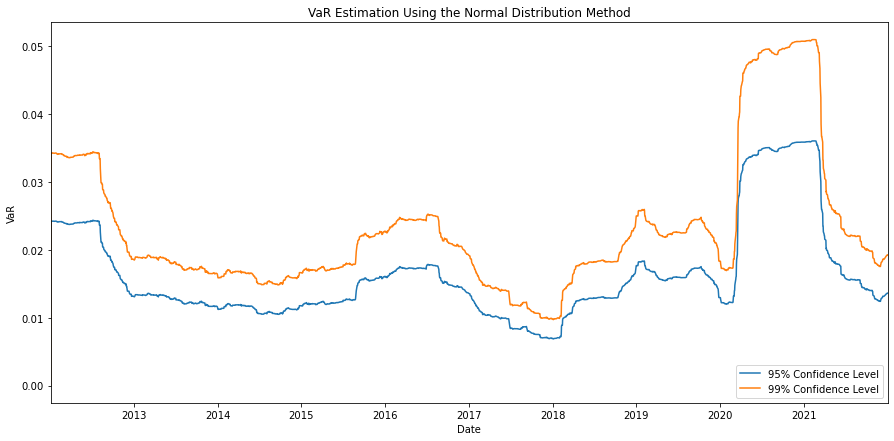

In [12]:
plt.plot(DateReturns[TestWindow[:-1]], Normal95[:-2], label="95% Confidence Level")
plt.plot(DateReturns[TestWindow[:-1]], Normal99[:-2], label="99% Confidence Level")
plt.xlim(DateReturns[TestWindow[0]], DateReturns[TestWindow[-2]])
plt.xlabel("Date")
plt.ylabel("VaR")
plt.legend(loc=4)
plt.title("VaR Estimation Using the Normal Distribution Method")

## Compute the VaR Using the Historical Simulation Method
Unlike the normal distribution method, the historical simulation (HS) is a nonparametric method. It does not assume a particular distribution of the asset returns. Historical simulation forecasts risk by assuming that past profits and losses can be used as the distribution of profits and losses for the next period of returns. The VaR "today" is computed as the p th-quantile of the last N returns prior to "today."

In [13]:
Historical95 = np.zeros(len(TestWindow) + 1).reshape(-1, 1)
Historical99 = np.zeros(len(TestWindow) + 1).reshape(-1, 1)


for t in TestWindow:
    i = t - TestWindowStart + 1
    EstimationWindow = list(range(t - EstimationWindowSize, t - 1))

    X = Returns[EstimationWindow[0] : EstimationWindow[-1] + 1]
    Historical95[i] = -mstats.mquantiles(X, pVaR[0], 0.5, 0.5)
    Historical99[i] = -mstats.mquantiles(X, pVaR[1], 0.5, 0.5);

Text(0.5, 1.0, 'VaR Estimation Using the Historical Simulation Method')

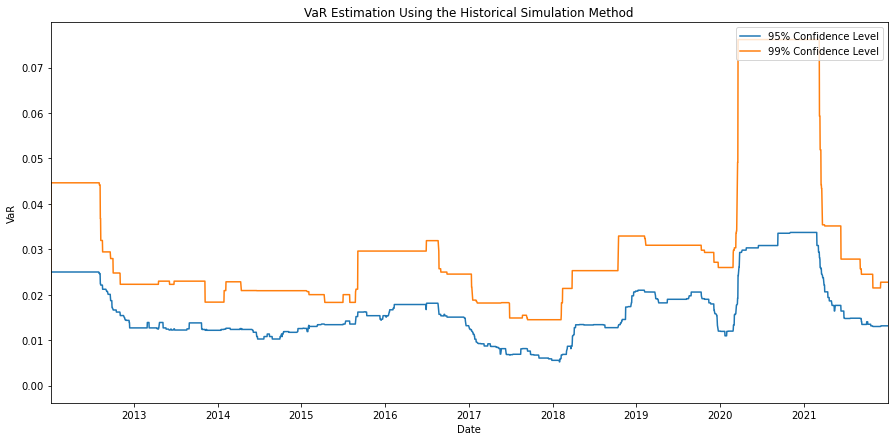

In [14]:
plt.plot(DateReturns[TestWindow[:-1]], Historical95[:-2], label="95% Confidence Level")
plt.plot(DateReturns[TestWindow[:-1]], Historical99[:-2], label="99% Confidence Level")
plt.xlim(DateReturns[TestWindow[0]], DateReturns[TestWindow[-2]])
plt.xlabel("Date")
plt.ylabel("VaR")
plt.legend(loc=1)
plt.title("VaR Estimation Using the Historical Simulation Method")

Compute the VaR Using the Exponential Weighted Moving Average Method (EWMA)The preceding figure shows that the historical simulation curve has a piecewise constant profile. The reason for this is that quantiles do not change for several days until extreme events occur. Thus, the historical simulation method is slow to react to changes in volatility.



## Compute the VaR Using the Exponential Weighted Moving Average Method (EWMA)

In [15]:
Returns = list(Returns["Close"])
Lambda = 0.94
Sigma2 = np.zeros(SampleSize + 1).reshape(-1, 1)
Sigma2[0] = Returns[0] ** 2

for i in range(2, TestWindowStart):
    Sigma2[i] = (1 - Lambda) * Returns[i - 1] ** 2 + Lambda * Sigma2[i - 1];
    # print(Sigma2[i])

In [16]:
Zscore = norm.ppf(pVaR)
EWMA95 = np.zeros(len(TestWindow) + 1).reshape(-1, 1)
EWMA99 = np.zeros(len(TestWindow) + 1).reshape(-1, 1)

for t in TestWindow:
    k = t - TestWindowStart + 1
    Sigma2[t] = (1 - Lambda) * Returns[t - 1] ** 2 + Lambda * Sigma2[t - 1]
    Sigma = (Sigma2[t]) ** (1 / 2)
    # print(Sigma)
    EWMA95[k] = -Zscore[0] * Sigma
    EWMA99[k] = -Zscore[1] * Sigma;

Text(0.5, 1.0, 'VaR Estimation Using the EWMA Method')

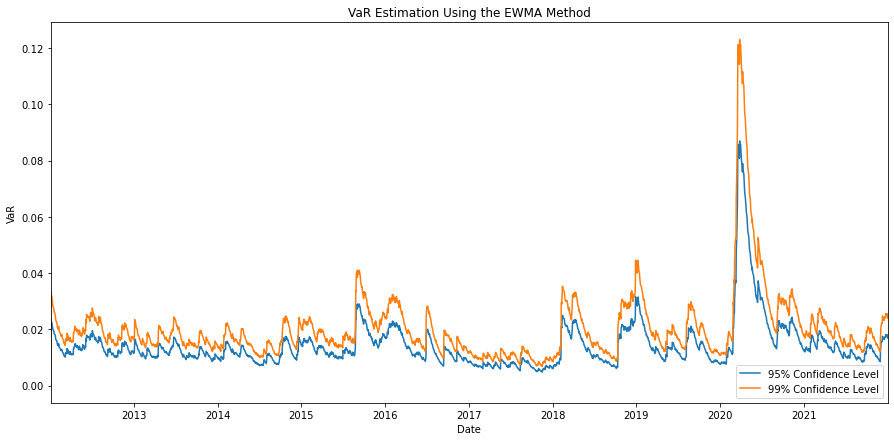

In [17]:
plt.plot(DateReturns[TestWindow[:-1]], EWMA95[:-2], label="95% Confidence Level")
plt.plot(DateReturns[TestWindow[:-1]], EWMA99[:-2], label="99% Confidence Level")
plt.xlim(DateReturns[TestWindow[0]], DateReturns[TestWindow[-2]])
plt.xlabel("Date")
plt.ylabel("VaR")
plt.legend(loc=4)
plt.title("VaR Estimation Using the EWMA Method")

## VaR Backtesting

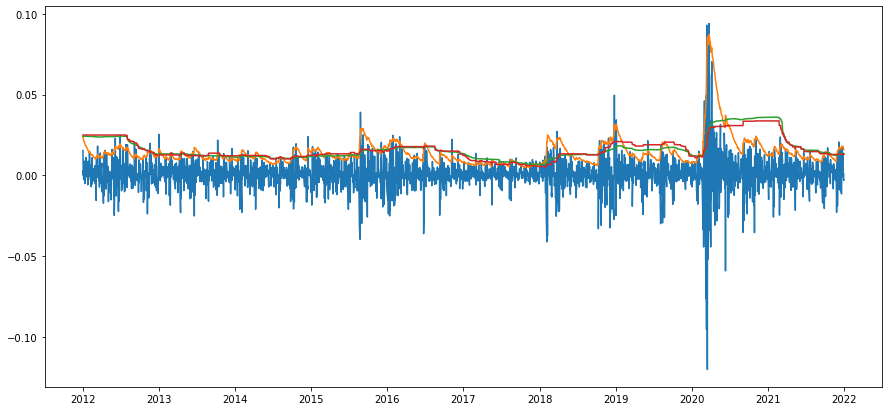

In [18]:
ReturnsTest = Returns[TestWindow[0] : TestWindow[-1]]
# ReturnsTest = [i + 0.025 for i in ReturnsTest]
DatesTest = DateReturns[TestWindow[:-1]]
# plot(DatesTest,[ReturnsTest -Normal95 -Historical95 -EWMA95])

plt.plot(DatesTest, ReturnsTest, label="95% Confidence Level")
plt.plot(DatesTest, EWMA95[2:], label="95% Confidence Level")
plt.plot(DatesTest, Normal95[2:], label="95% Confidence Level")
plt.plot(DatesTest, Historical95[2:], label="95% Confidence Level")


# ylabel('VaR')
# xlabel('Date')
# legend({'Returns','Normal','Historical','EWMA'},'Location','Best')
# title('Comparison of returns and VaR at 95% for different models')

In [19]:
start = DatesTest.get_loc("2016-01-04")
end = DatesTest.get_loc("2016-12-01")
start, end

(1006, 1237)

In [20]:
def getLessIndex(listA, listB):
    res = []
    for i in range(len(listA)):
        if listA[i] < listB[i]:
            res.append(i)
    return res

(16804.0, 17134.0)

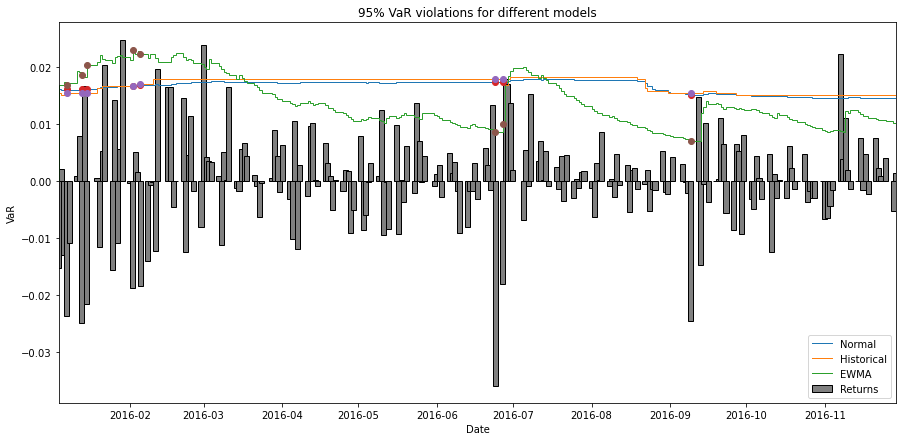

In [21]:
ZoomInd = list(range(start, end))

VaRData = [Normal95[ZoomInd], Historical95[ZoomInd], EWMA95[ZoomInd]]

VaRFormat = ["-", "--", "-."]
VaRLegend = ["Normal", "Historical", "EWMA"]


D = DatesTest[ZoomInd[0] : ZoomInd[-1]]
R = ReturnsTest[ZoomInd[0] : ZoomInd[-1]]

N = Normal95[ZoomInd[0] : ZoomInd[-1]]
H = Historical95[ZoomInd[0] : ZoomInd[-1]]
E = EWMA95[ZoomInd[0] : ZoomInd[-1]]


IndN95 = getLessIndex(R, -N)
IndHS95 = getLessIndex(R, -H)
IndEWMA95 = getLessIndex(R, -E)


# figure;
plt.bar(D, R, 2, color="gray", edgecolor="black", label="Returns")

# hold on
for i in range(len(VaRData)):
    plt.stairs(VaRData[i][:-2, 0], D, label=VaRLegend[i])
# end
plt.ylabel("VaR")
plt.xlabel("Date")
plt.legend(loc=4)
plt.title("95% VaR violations for different models")


plt.plot(D[IndN95], N[IndN95], "o")
plt.plot(D[IndN95], H[IndN95], "o")
plt.plot(D[IndN95], E[IndN95], "o")

plt.xlim([D[0], D[-1]])

A VaR failure or violation happens when the returns have a negative VaR. A closer look around August 27 to August 31 shows a significant dip in the returns. On the dates starting from August 27 onward, the EWMA follows the trend of the returns closely and more accurately. Consequently, EWMA has fewer VaR violations (two (2) violations, yellow diamonds) compared to the Normal Distribution approach (seven (7) violations, blue stars) or the Historical Simulation method (eight (8) violations, red squares).

Besides visual tools, you can use statistical tests for VaR backtesting. In Risk Management Toolbox™, a varbacktest object supports multiple statistical tests for VaR backtesting analysis. In this example, start by comparing the different test results for the normal distribution approach at the 95% and 99% VaR levels.m

In [22]:
from varbacktests import VaRBackTest

In [23]:
vbt = VaRBackTest(ReturnsTest , varData = [Normal95, Normal99] , \
          varID = ['Normal95','Normal99'], varLevel=[0.95, 0.99])

In [24]:
vbt.summary()

+---------------+----------+----------+-------------------+--------------+----------+--------------------+--------------------+--------------+---------+
|   PorfolioID  |  VarID   | VarLevel | ObservationsLevel | Observations | Failures |      Excepted      |       Ratio        | FirstFailure | Missing |
+---------------+----------+----------+-------------------+--------------+----------+--------------------+--------------------+--------------+---------+
| ['S&P Index'] | Normal95 |   0.95   |        0.95       |    2519.0    |  124.0   | 125.95000000000012 | 0.9845176657403722 |    104.0     |   0.0   |
| ['S&P Index'] | Normal99 |   0.99   |        0.99       |    2519.0    |   64.0   | 25.190000000000023 | 2.5406907502977347 |    213.0     |   0.0   |
+---------------+----------+----------+-------------------+--------------+----------+--------------------+--------------------+--------------+---------+


The summary report shows that the observed level is close enough to the defined VaR level. The 95% and 99% VaR levels have at most (1-VaR_level) x N expected failures, where N is the number of observations. The failure ratio shows that the Normal95 VaR level is within range, whereas the Normal99 VaR Level is imprecise and under-forecasts the risk. To run all tests supported in varbacktest, use runtests.

In [25]:
vbt.runtests()

+-------------+----------+-----+--------+--------+--------+--------+--------+--------+--------+
| PortfolioID |  VarID   |  TL |  Bin   |  Pof   |  Tuff  |   CC   |  CCI   |  Tbfi  |  Tbf   |
+-------------+----------+-----+--------+--------+--------+--------+--------+--------+--------+
|  S&P Index  | Normal95 | red | reject | accept | reject | accept | accept | reject | reject |
|  S&P Index  | Normal99 | red | reject | reject | reject | accept | accept | reject | reject |
+-------------+----------+-----+--------+--------+--------+--------+--------+--------+--------+


The 95% VaR passes the frequency tests, such as traffic light, binomial and proportion of failures tests (tl, bin, and pof columns). The 99% VaR does not pass these same tests, as indicated by the yellow and reject results. Both confidence levels got rejected in the conditional coverage independence, and time between failures independence (cci and tbfi columns). This result suggests that the VaR violations are not independent, and there are probably periods with multiple failures in a short span. Also, one failure may make it more likely that other failures will follow in subsequent days. For more information on the tests methodologies and the interpretation of results, see varbacktest and the individual tests.

Using a varbacktest object, run the same tests on the portfolio for the three approaches at both VaR confidence levels.`

In [26]:
vbt = VaRBackTest(ReturnsTest,[Normal95,Historical95,EWMA95,Normal99,Historical99, \
    EWMA99],portfolioID = 'S&P Index', varID = ['Normal95','Historical95','EWMA95', \
    'Normal99','Historical99','EWMA99'], varLevel = [0.95,0.95,0.95,0.99,0.99,0.99])
vbt.runtests()

+-------------+--------------+-----+--------+--------+--------+--------+--------+--------+--------+
| PortfolioID |    VarID     |  TL |  Bin   |  Pof   |  Tuff  |   CC   |  CCI   |  Tbfi  |  Tbf   |
+-------------+--------------+-----+--------+--------+--------+--------+--------+--------+--------+
|      S      |   Normal95   | red | reject | accept | reject | accept | accept | reject | reject |
|      S      | Historical95 | red | reject | accept | reject | accept | accept | reject | reject |
|      S      |    EWMA95    | red | reject | accept | reject | accept | accept | reject | reject |
|      S      |   Normal99   | red | reject | reject | reject | accept | accept | reject | reject |
|      S      | Historical99 | red | reject | accept | reject | accept | accept | reject | reject |
|      S      |    EWMA99    | red | reject | reject | reject | accept | accept | reject | reject |
+-------------+--------------+-----+--------+--------+--------+--------+--------+--------+--------+


The results are similar to the previous results, and at the 95% level, the frequency results are generally acceptable. However, the frequency results at the 99% level are generally rejections. Regarding independence, most tests pass the conditional coverage independence test (cci), which tests for independence on consecutive days. Notice that all tests fail the time between failures independence test (tbfi), which takes into account the times between all failures. This result suggests that all methods have issues with the independence assumption.

To better understand how these results change given market conditions, look at the years 2000 and 2002 for the 95% VaR confidence level.

In [28]:
start = DatesTest.get_loc("2020-01-02")
end = DatesTest.get_loc("2020-12-31")
start, end


vbt2020 = VaRBackTest(ReturnsTest[start:end],[Normal95[start:end],\
                                        Historical95[start:end], EWMA95[start:end]],\
                                       portfolioID="S&P, 2000",varID=['Normal','Historical','EWMA'], varLevel=[0.95,0.95,0.95])
vbt2020.runtests()

+-------------+------------+-----+--------+--------+--------+--------+--------+--------+--------+
| PortfolioID |   VarID    |  TL |  Bin   |  Pof   |  Tuff  |   CC   |  CCI   |  Tbfi  |  Tbf   |
+-------------+------------+-----+--------+--------+--------+--------+--------+--------+--------+
|      S      |   Normal   | red | reject | reject | accept | accept | accept | reject | reject |
|      S      | Historical | red | reject | reject | accept | accept | accept | reject | reject |
|      S      |    EWMA    | red | reject | accept | accept | accept | accept | reject | reject |
+-------------+------------+-----+--------+--------+--------+--------+--------+--------+--------+


In [29]:
start = DatesTest.get_loc("2021-01-04")
end = DatesTest.get_loc("2021-12-30")
start, end


vbt2021 = VaRBackTest(ReturnsTest[start:end],[Normal95[start:end],\
                                        Historical95[start:end], EWMA95[start:end]],\
                                       portfolioID="S&P, 2001",varID=['Normal','Historical','EWMA'], varLevel=[0.95,0.95,0.95])
vbt2021.runtests()

+-------------+------------+-----+--------+--------+--------+--------+--------+--------+--------+
| PortfolioID |   VarID    |  TL |  Bin   |  Pof   |  Tuff  |   CC   |  CCI   |  Tbfi  |  Tbf   |
+-------------+------------+-----+--------+--------+--------+--------+--------+--------+--------+
|      S      |   Normal   | red | reject | reject | reject | accept | accept | reject | reject |
|      S      | Historical | red | reject | reject | reject | accept | accept | reject | reject |
|      S      |    EWMA    | red | reject | accept | accept | accept | accept | accept | accept |
+-------------+------------+-----+--------+--------+--------+--------+--------+--------+--------+


For the year 2000, all three methods pass all the tests. However, for the year 2002, the test results are mostly rejections for all methods. The EWMA method seems to perform better in 2002, yet all methods fail the independence tests.

To get more insight into the independence tests, look into the conditional coverage independence (cci) and the time between failures independence (tbfi) test details for the year 2002. To access the test details for all tests, run the individual test functions

In [30]:
vbt2021.tbfi()

+-------------+------------+----------+--------+--------------------+--------------------+--------------+----------+--------+-------+-------+-------+--------+----------------------+
| PortfolioID |   VaRID    | VaRLevel |  TBFI  |     LRatioTBFI     |     PValueTBFI     | Observations | Failures | TBFMin | TBFQ1 | TBFQ2 | TBFQ3 | TBFMax |      TestLevel       |
+-------------+------------+----------+--------+--------------------+--------------------+--------------+----------+--------+-------+-------+-------+--------+----------------------+
|  S&P, 2001  |   Normal   |   0.95   | reject | 12.98645283977272  | 0.9567484180340269 |     250      |    6     |  0.0   |  0.0  |  3.0  |  24.0 |  46.0  | 0.050000000000000044 |
|  S&P, 2001  | Historical |   0.95   | reject | 12.98645283977272  | 0.9567484180340269 |     250      |    6     |  0.0   |  0.0  |  3.0  |  24.0 |  46.0  | 0.050000000000000044 |
|  S&P, 2001  |    EWMA    |   0.95   | accept | 22.025604217513724 | 0.9450336747356916 |